In [1]:
%matplotlib inline
import datetime
import json
import tldextract
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import seaborn as sns
from matplotlib import pyplot as plt
from PIL import Image
from wordcloud import WordCloud, STOPWORDS

In [ ]:
with open("BrowserHistory.json", "rb") as f:
    data = json.loads(f.read())
    hst = pd.DataFrame(data["Browser History"])

In [ ]:
hst.drop('client_id', axis=1, inplace=True)
hst.drop('favicon_url', axis=1, inplace=True)
hst.sample(1)

,page_transition,title,url,time_usec
68039,LINK,Seriale anime – Netflix,https://www.netflix.com/browse/genre/6721?bc=83,1647160633226541


In [ ]:
def convert_time(x):
    return datetime.datetime.fromtimestamp(x/1000000)
hst['dt'] = hst['time_usec'].apply(convert_time)

In [ ]:
def get_date(x):
    return str(x.date())
hst['date'] = hst['dt'].apply(get_date)

In [ ]:
def get_hour(x):
    return int(x.hour)
hst['hour'] = hst['dt'].apply(get_hour)

In [ ]:
def get_month(x):
    return int(x.month)
hst['month'] = hst['dt'].apply(get_month)


In [ ]:
def get_year(x):
    return int(x.year)
hst['year'] = hst['dt'].apply(get_year)

In [ ]:
def get_is_secure(x):
    if x.startswith("https"):
        return "Y"
    return "N"
hst['is_secure'] = hst['url'].apply(get_is_secure)

In [ ]:
def get_weekend(x):
    if x.weekday() >= 5:
        return "Y"
    return "N"
hst['is_weekend'] = hst['dt'].apply(get_weekend)

In [ ]:
days_array = ['Mon', 'Tue', 'Wedn', 'Thur', 'Friday', 'Sat', 'Sun']
def get_day(x):
    return days_array[x.weekday()]
hst['day_of_week'] = hst['dt'].apply(get_day)


In [ ]:
def get_domain(x):
    domain = tldextract.extract(x)[1]
    sub_domain = tldextract.extract(x)[0]
    if sub_domain == "mail":
        return sub_domain + "." + domain
    if domain == "google" and sub_domain == "www":
        return "google_search"
    return domain
hst['domain'] = hst['url'].apply(get_domain)


In [ ]:
def get_category(x):
    if x in ['udemy', 'stackoverflow', 'kaggle']:
        return 'Learning'
    elif x in ['facebook', 'messenger', 'instagram', 'reddit', 'discord', 'twitch', 'twitter']:
        return 'Socials'
    elif x in ['allegro', 'amzaon', 'shopee', 'pepper', 'olx']:
        return 'Shopping'
    elif x in ['mail.google']:
        return 'mail'
    elif x in ['youtube', 'spotify']:
        return 'Music'
    else:
        return 'other'
hst['category'] = hst['domain'].apply(get_category)


In [ ]:
hst = hst[(hst['page_transition'] == "LINK") | (hst['page_transition'] == "TYPED")]
hst = hst[hst['domain'] != 'newtab']
hst.sample(1)
           

,page_transition,title,url,time_usec,dt,date,hour,month,year,is_secure,is_weekend,day_of_week,domain,category
33584,LINK,ten jeden typ z siłowni - YouTube,https://www.youtube.com/watch?v=c6avlhO1wV4&ab...,1653412157263741,2022-05-24 19:09:17.263741,2022-05-24,19,5,2022,Y,N,Tue,youtube,Music


<h1>Website visits ratio weekend vs weekday</h1>

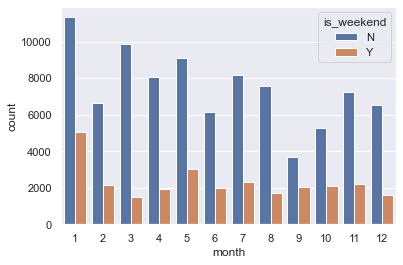

In [ ]:
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="month", hue = "is_weekend", data=hst)



<h1>Heatmap of visits per day</h1>

In [ ]:
hst_heat = hst.groupby(["hour", "day_of_week"])["domain"].size().reset_index()
hst_heat2 = hst_heat.pivot("hour", "day_of_week", "domain")

<AxesSubplot:xlabel='day_of_week', ylabel='hour'>

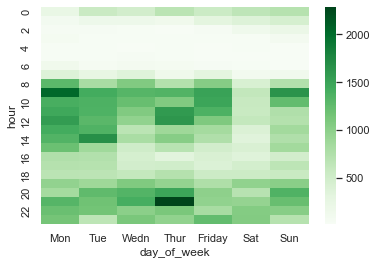

In [ ]:
sns.heatmap(hst_heat2[days_array] , cmap="Greens")

<h1> Visits per hour in category Socials, defined by hour</h1>

<AxesSubplot:xlabel='hour', ylabel='count'>

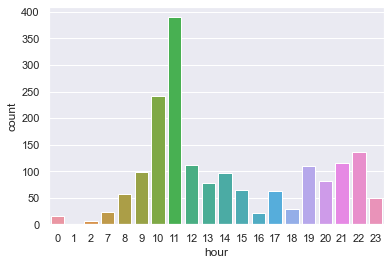

In [ ]:
sns.countplot(x='hour', data=hst[(hst['category'] == "Socials") & (hst['month'] == 12)])

<h1> Browser usage over month in 2022</h1>

In [ ]:
hst_month = hst[(hst['month'] == 7) & (hst['year'] == 2022)].groupby(['hour', 'date'])['domain'].nunique()
hst_month = hst_month.reset_index(name='count')

<AxesSubplot:xlabel='date', ylabel='hour'>

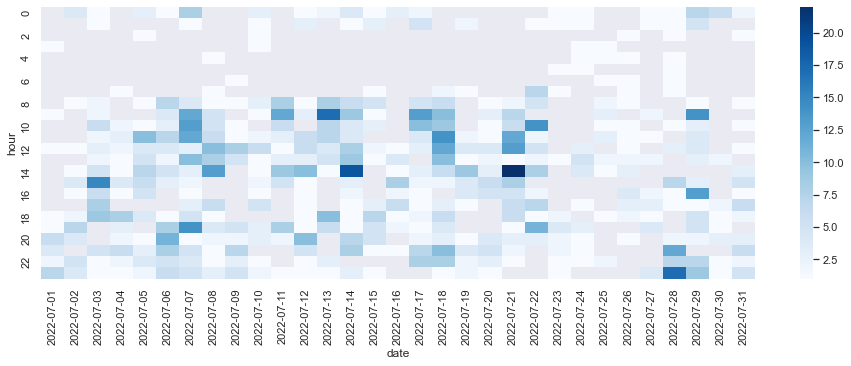

In [ ]:
plt.figure(figsize = (16,5))
sns.heatmap(hst_month.pivot('hour', 'date', 'count'), annot = False, cmap = "Blues")

<h1>Category usage over months </h1>

<AxesSubplot:xlabel='month', ylabel='count'>

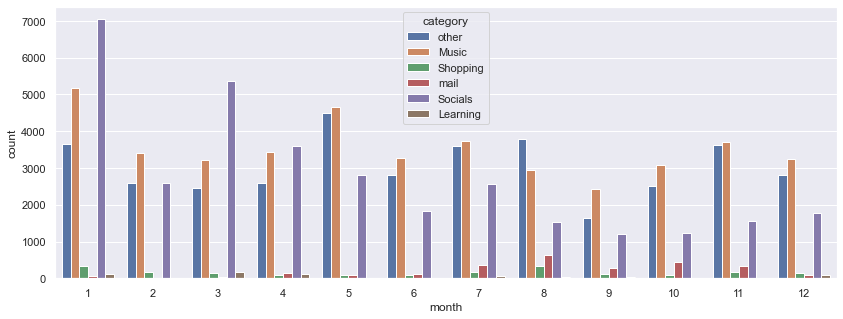

In [ ]:
plt.figure(figsize = (14,5))
sns.countplot(x='month', hue='category', data=hst)

<h1>Most revisited</h1> 

In [ ]:
pd.set_option('display.max_colwidth', None)
hst_yt = hst[hst['domain'] == "stackoverflow"].groupby(['url', 'title']).size()
hst_yt = hst_yt.reset_index(name='count').sort_values('count', ascending=False)[['title', 'count']]

hst_yt.head(10)

,title,count
63,python - How to group FastAPI endpoints in Swagger UI? - Stack Overflow,2
36,python - 'pip' is not recognized - Stack Overflow,2
6,"excel - ""Clicking"" Command Button from other workbook - Stack Overflow",2
55,python - Generate a random date between two other dates - Stack Overflow,2
47,python - How to create and fill a list of lists in a for loop - Stack Overflow,2
0,"Stack Overflow - Where Developers Learn, Share, & Build Careers",1
53,Preventing nested grouping when adding rows to pivot table in Excel - Stack Overflow,1
52,Python - How to recall the correct function - Stack Overflow,1
51,python - Why do I get <built-in method title of str object at 0x7fb554f9f238> instead of the value ? - Stack Overflow,1
50,"python - Difference between using ' and ""? - Stack Overflow",1


<h1> Other Visualisation about all categories</h1>

<AxesSubplot:xlabel='category', ylabel='hour'>

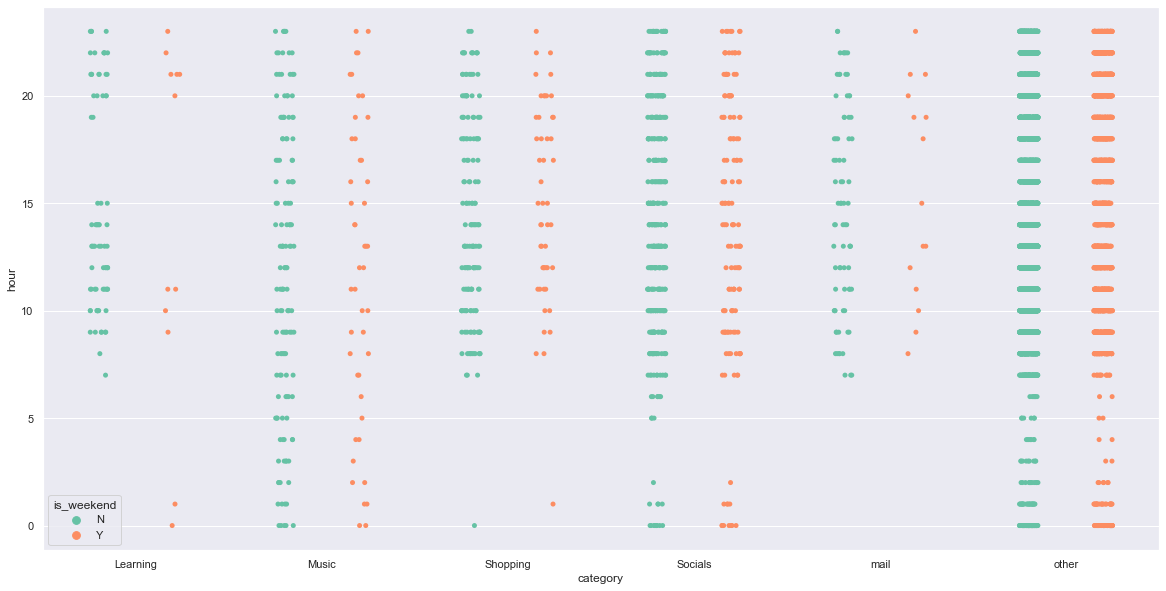

In [ ]:
hst_cat = hst[(hst['year'] == 2022)].groupby(['category', 'day_of_week', 'hour', 'domain', 'is_weekend']).size().reset_index()
plt.figure(figsize = (20,10))
sns.stripplot(x='category', y='hour', hue = 'is_weekend', data = hst_cat, jitter=True, dodge=True, palette='Set2')

<h1> Category usage over month</h1>

In [ ]:
 aug = hst.loc[(hst['month'] == 7) & (hst['year'] == 2022)]


<AxesSubplot:xlabel='month', ylabel='count'>

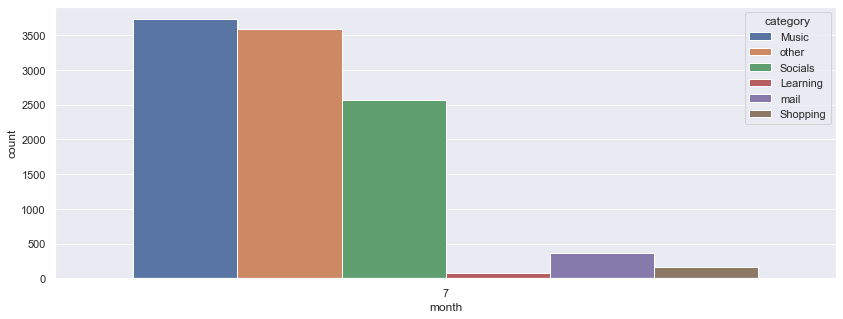

In [ ]:
plt.figure(figsize = (14,5))
sns.countplot(x='month', hue='category', data=aug)